In [1]:
#Uploading required packages
import numpy as np
from scipy.stats import gamma
from scipy.stats import uniform as unif
from scipy.stats import multivariate_normal as mvtnorm
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Data Simulation

#Latent Features
W = np.array([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])


#Each image in our simulated data set is the superposition of four base images#
# Number of images/ data points
num_objects=100

#Dimension of image (6x6)
object_dim  = 6*6

#Covariance matrix for images/ white noise
sigma_x_orig = 0.5
I = sigma_x_orig * np.identity(object_dim)

#z_i - binary feature matrix (1 x 4) - each entry set to 1 with probability 0.5 and 0 otherwise#
#x is data variable - each row correspondes to a superimposed built from a random combination of latent features#
#with white noise added - x is built with multivariate gaussian#
image_data = np.zeros((100,36))
z_org = np.zeros((100,4))

for i in range(0,num_objects):
    z_org[i,:] = np.array([bernoulli.rvs(p=0.5, size=4)])
    image_data[i,:] = np.dot(z_org[i,:],W) + np.random.normal(0,1, (1,object_dim)).dot(I)    

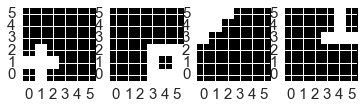

In [3]:
##Latent Features
fig = plt.figure()
a=fig.add_subplot(1,4,1)
plt.imshow(np.matrix(W[0]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,2)
plt.imshow(np.matrix(W[1]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,3)
plt.imshow(np.matrix(W[2]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,4,4)
plt.imshow(np.matrix(W[3]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
plt.show()

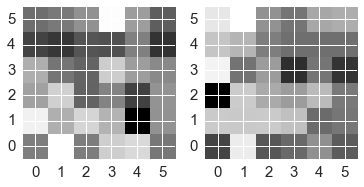

In [4]:
#Simulated Data
fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(np.matrix(image_data[0,:]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,2,2)
plt.imshow(np.matrix(image_data[1,:]).reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
plt.show()

In [5]:
# Indian Buffet Process Function

def sampleIBP(alpha, num_objects):  
    # Initializing storage for results
    result = np.zeros([num_objects, 1000])
    # Draw from the prior for alpha
    t = np.random.poisson(alpha)
    # Filling in first row of result matrix
    result[0, 0:t] = np.ones(t) #changed form np.ones([1, t])
    # Initializing K+
    K_plus = t
    
    for i in range(1, num_objects):
        for j in range(0, K_plus):
            p = np.array([np.log(np.sum(result[0:i,j])) - np.log(i+1), 
                          np.log(i+1 - np.sum(result[0:i, j])) - np.log(i+1)])
            p = np.exp(p - max(p))

            if(np.random.uniform() < p[0]/np.sum(p)):
                result[i, j] = 1
            else:
                result[i, j] = 0
        t = np.random.poisson(alpha/(i+1))
        x = K_plus + 1
        y = K_plus + t
        result[i, (x-1):y] = np.ones(t) #changed form np.ones([1, t])
        K_plus = K_plus+t
    result = result[:, 0:K_plus]
    
    return list([result, K_plus])

Run 1: Unoptimized version
====

In [6]:
# This function return the log likelihood
def likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det((np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)))) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,M),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)

In [8]:
data = image_data

#Set number of iterations
E = 1000

#Set truncation limit for max number of sampled latent features
K_inf = 20

#Set storage arrays for sampled parameters
chain_Z = np.zeros([E, num_objects, K_inf])
chain_K = np.zeros([E, 1])
chain_sigma_X = np.zeros([E, 1])
chain_sigma_A = np.zeros([E, 1])
chain_alpha = np.zeros([E, 1])

#Initialize parameter values
sigma_X = 1
sigma_A = 1
alpha = 1
num_object= np.shape(data)[0]
object_dim = np.shape(data)[1]
[Z, K_plus] = sampleIBP(alpha, num_objects)

#Compute Harmonic Number
HN = 0
for i in range(0, num_objects):
    HN = HN + 1/(i+1)

for e in range(0, E):

    #Store sampled values
    chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
    chain_K[e] = K_plus
    chain_sigma_X[e] = sigma_X
    chain_sigma_A[e] = sigma_A
    chain_alpha[e] = alpha
    
    if (e%100==0):
        print(e)
    print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

    #Generate a new value for Z[i,k] and accept by Metropolis
    for i in range(0, num_objects):
        #First we remove singular features if any
        for k in range(0, K_plus):
            if (k>=K_plus):
                break
            if(Z[i, k] > 0):
                if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                    Z[i, k] = 0
                    Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                    K_plus = K_plus - 1
                    Z = Z[:, 0:K_plus]
                    continue
            #Compute conditional distribution for current cell
            P=np.zeros(2)

            Z[i,k]=1
            M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2) * np.eye(K_plus))
            P[0] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

            Z[i,k]=0
            M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2) * np.eye(K_plus))
            P[1] = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

            P = np.exp(P - np.max(P))

            #Sample from conditional(sampling previously sampled dishes)
            if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
                Z[i, k] = 1
            else:
                Z[i, k] = 0
                
        #Sample new dishes by Metropolis
        trunc = np.zeros(5)
        alpha_N = alpha/num_objects

        for k_i in range(0,5):
            Z_temp = Z
            if k_i>0:
                newcol = np.zeros((num_objects, k_i))
                newcol[i,:] = 1 
                Z_temp = np.column_stack((Z_temp, newcol))
            M = np.linalg.inv(np.dot(Z_temp.T, Z_temp) + (sigma_X**2/sigma_A**2) * np.eye(K_plus + k_i))
            trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood(data, Z_temp, M, sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

        trunc = np.exp(trunc - np.max(trunc))
        trunc = trunc/np.sum(trunc)

        p = np.random.uniform(0,1)
        t = 0
        new_dishes = 0

        for k_i in range(0,5):
            t = t + trunc[k_i]
            if p < t:
                new_dishes = k_i
                break

        if(new_dishes > 0):
            newcol = np.zeros((num_objects, new_dishes))
            newcol[i,:] = 1
            Z = np.column_stack((Z, newcol))
        K_plus = K_plus + new_dishes

    #Sample sigma_X and sigma_A through Metropolis
    M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2) * np.eye(K_plus))
    lik_curr = likelihood(data, Z, M, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X_new**2/sigma_A**2) * np.eye(K_plus))
    lik_new_X = likelihood(data, Z, M, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    M = np.linalg.inv(np.dot(Z.T, Z) + (sigma_X**2/sigma_A_new**2) * np.eye(K_plus))
    lik_new_A = likelihood(data, Z, M, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))

    if np.random.uniform(0,1) < acc_X:
        sigma_X = sigma_X_new
    if np.random.uniform(0,1) < acc_A:
        sigma_A = sigma_A_new

    #Sample alpha via Gibbs
    alpha = np.random.gamma(1 + K_plus, 1/(1+HN))

print("Complete")

0
At iteration 0 : K_plus is 3 , alpha is 1
At iteration 1 : K_plus is 1 , alpha is 0.2628577715416496
At iteration 2 : K_plus is 1 , alpha is 0.12130287056799126
At iteration 3 : K_plus is 1 , alpha is 0.05931375767874137
At iteration 4 : K_plus is 1 , alpha is 0.5915310711871866
At iteration 5 : K_plus is 1 , alpha is 0.2532358625520888
At iteration 6 : K_plus is 1 , alpha is 0.14450268757760087
At iteration 7 : K_plus is 1 , alpha is 0.2990217763307206
At iteration 8 : K_plus is 1 , alpha is 0.725146080452738
At iteration 9 : K_plus is 1 , alpha is 0.5094152100387976
At iteration 10 : K_plus is 1 , alpha is 0.07573510507193074
At iteration 11 : K_plus is 1 , alpha is 0.07110683639311202
At iteration 12 : K_plus is 1 , alpha is 0.046045012285055545
At iteration 13 : K_plus is 1 , alpha is 0.15602744452707537
At iteration 14 : K_plus is 1 , alpha is 0.4286171585956383
At iteration 15 : K_plus is 1 , alpha is 0.3652753563948779
At iteration 16 : K_plus is 1 , alpha is 0.128752240937552

KeyboardInterrupt: 

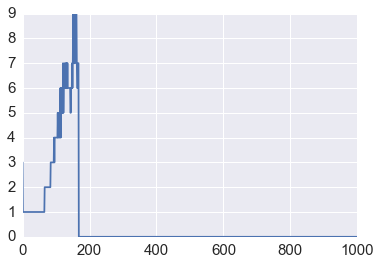

In [9]:
#plot K_plus
plt.plot(np.arange(1000), np.squeeze(chain_K, axis=(1,)))
plt.show()

<function matplotlib.pyplot.show>

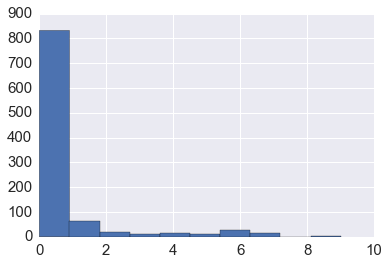

In [10]:
plt.hist(np.squeeze(chain_K, axis=(1,)))
plt.show

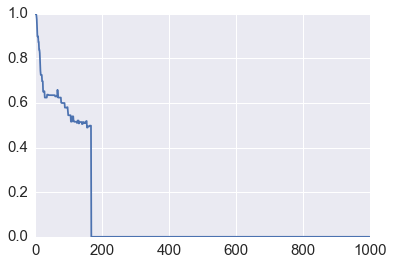

In [11]:
#Plot sigma_X
plt.plot(np.arange(1000), np.squeeze(chain_sigma_X, axis=(1,)))
plt.show()

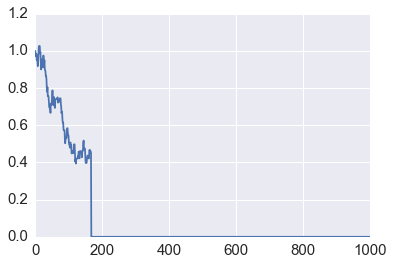

In [12]:
#Plot sigma_A
plt.plot(np.arange(1000), np.squeeze(chain_sigma_A, axis=(1,)))
plt.show()

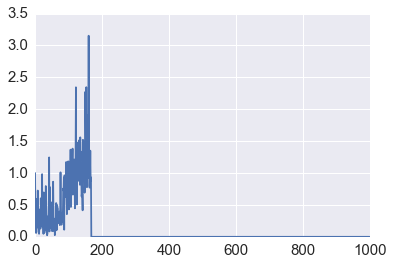

In [13]:
#Plot alpha
plt.plot(np.arange(1000), np.squeeze(chain_alpha, axis=(1,)))
plt.show()

In [14]:
K_post_choice = 5
final_Z = chain_Z[999,:,0:K_post_choice]
post_sigma_X_mean = np.mean(np.squeeze(chain_sigma_X, axis=(1,))[50:])
post_sigma_A_mean = np.mean(np.squeeze(chain_sigma_A, axis=(1,))[50:])
M_fin = np.linalg.inv(np.dot(final_Z.T, final_Z) + (post_sigma_X_mean**2/post_sigma_A_mean**2) * np.eye(K_post_choice))
post_exp_A  = np.dot(M_fin, np.dot(final_Z.T, data))

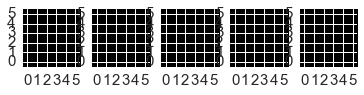

In [15]:
##Latent Features
fig = plt.figure()
a=fig.add_subplot(1,5,1)
plt.imshow(post_exp_A[0,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,2)
plt.imshow(post_exp_A[1,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,3)
plt.imshow(post_exp_A[2,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,4)
plt.imshow(post_exp_A[3,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,5)
plt.imshow(post_exp_A[4,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
pass

Run 2: Optimized version
====

In [16]:
## Optimized likelihood
# This function return the log likelihood
def likelihood_opt(X, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim):
    #Calculate M
    M = np.dot(Z.T, Z) + (sigma_X**2/sigma_A**2)*np.eye(K_plus)
    
    part1 = (-1)*num_objects*(0.5*object_dim)*np.log(2*np.pi)
    part2 = (-1)*(num_objects-K_plus)* object_dim *np.log(sigma_X) 
    part3 = (-1)*object_dim*K_plus*np.log(sigma_A) 
    part4 = (-1)*(0.5*object_dim)* np.log(np.linalg.det(M)) 
    part5 = (-1/(2*sigma_X**2)) * np.trace(np.dot(np.dot(X.T,(np.identity(num_objects) - np.dot(np.dot(Z,np.linalg.inv(M)),Z.T))),X))
    total = part1+part2+part3+part4+part5
    return(total)


In [26]:
%%time
data = image_data

#Set number of iterations
E = 10

#Set truncation limit for max number of sampled latent features
K_inf = 20

#Set storage arrays for sampled parameters
chain_Z = np.zeros([E, num_objects, K_inf])
chain_K = np.zeros([E, 1])
chain_sigma_X = np.zeros([E, 1])
chain_sigma_A = np.zeros([E, 1])
chain_alpha = np.zeros([E, 1])

#Initialize parameter values
sigma_X = 1
sigma_A = 1
alpha = 1
num_object= np.shape(data)[0]
object_dim = np.shape(data)[1]
[Z, K_plus] = sampleIBP(alpha, num_objects)

#Compute Harmonic Number
HN = 0
for i in range(0, num_objects):
    HN = HN + 1/(i+1)

for e in range(0, E):

    #Store sampled values
    chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
    chain_K[e] = K_plus
    chain_sigma_X[e] = sigma_X
    chain_sigma_A[e] = sigma_A
    chain_alpha[e] = alpha
    
    if (e%100==0):
        print(e)
    
    print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

    #Generate a new value for Z[i,k] and accept by Metropolis
    for i in range(0, num_objects):
        #First we remove singular features if any
        for k in range(0, K_plus):
            if (k>=K_plus):
                break
            if(Z[i, k] > 0):
                if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                    Z[i, k] = 0
                    Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                    K_plus = K_plus - 1
                    Z = Z[:, 0:K_plus]
                    continue
            #Compute conditional distribution for current cell
            P=np.zeros(2)

            Z[i,k]=1
            P[0] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

            Z[i,k]=0
            P[1] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

            P = np.exp(P - np.max(P))

            #Sample from conditional(sampling previously sampled dishes)
            if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
                Z[i, k] = 1
            else:
                Z[i, k] = 0
                
        #Sample new dishes by Metropolis
        trunc = np.zeros(5)
        alpha_N = alpha/num_objects

        for k_i in range(0,5):
            Z_temp = Z
            if k_i>0:
                newcol = np.zeros((num_objects, k_i))
                newcol[i,:] = 1 
                Z_temp = np.column_stack((Z_temp, newcol))
            trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood_opt(data, Z_temp,sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

        trunc = np.exp(trunc - np.max(trunc))
        trunc = trunc/np.sum(trunc)

        p = np.random.uniform(0,1)
        t = 0
        new_dishes = 0

        for k_i in range(0,5):
            t = t + trunc[k_i]
            if p < t:
                new_dishes = k_i
                break

        if(new_dishes > 0):
            newcol = np.zeros((num_objects, new_dishes))
            newcol[i,:] = 1
            Z = np.column_stack((Z, newcol))
        K_plus = K_plus + new_dishes

    #Sample sigma_X and sigma_A through Metropolis
    lik_curr = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

    if np.random.uniform(0,1) < 0.5:
        sigma_X_new = sigma_X - np.random.uniform(0,1)/20
    else:
        sigma_X_new = sigma_X + np.random.uniform(0,1)/20

    lik_new_X = likelihood_opt(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

    acc_X = np.exp(min(0, lik_new_X - lik_curr))

    if np.random.uniform(0,1) < 0.5:
        sigma_A_new = sigma_A - np.random.uniform(0,1)/20
    else:
        sigma_A_new = sigma_A + np.random.uniform(0,1)/20

    lik_new_A = likelihood_opt(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

    acc_A = np.exp(min(0, lik_new_A - lik_curr))

    if np.random.uniform(0,1) < acc_X:
        sigma_X = sigma_X_new
    if np.random.uniform(0,1) < acc_A:
        sigma_A = sigma_A_new

    #Sample alpha via Gibbs
    alpha = np.random.gamma(1 + K_plus, 1/(1+HN))

print("Complete")

0
At iteration 0 : K_plus is 9 , alpha is 1
At iteration 1 : K_plus is 6 , alpha is 1.2922958480810438
At iteration 2 : K_plus is 3 , alpha is 0.2098769687728331
At iteration 3 : K_plus is 3 , alpha is 0.8180345697412885
At iteration 4 : K_plus is 2 , alpha is 0.3729958157061544
At iteration 5 : K_plus is 2 , alpha is 0.5935325409292281
At iteration 6 : K_plus is 2 , alpha is 0.4642214886749749
At iteration 7 : K_plus is 2 , alpha is 0.6589125214220951
At iteration 8 : K_plus is 2 , alpha is 1.0708172396065574
At iteration 9 : K_plus is 2 , alpha is 0.367521207966429
Complete
Wall time: 9.08 s


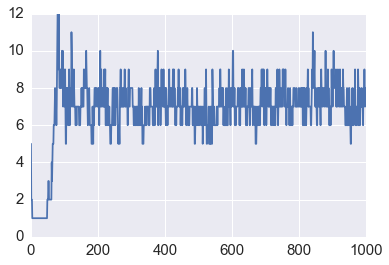

In [19]:
#plot K_plus
plt.plot(np.arange(1000), np.squeeze(chain_K, axis=(1,)))
plt.show()

<function matplotlib.pyplot.show>

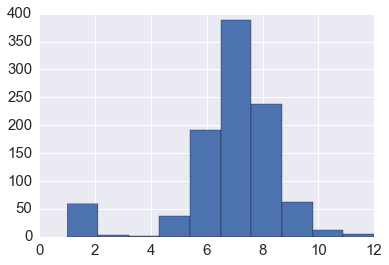

In [20]:
plt.hist(np.squeeze(chain_K, axis=(1,)))
plt.show

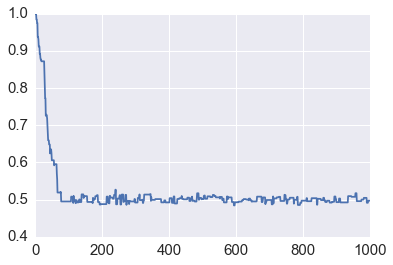

In [21]:
#Plot sigma_X
plt.plot(np.arange(1000), np.squeeze(chain_sigma_X, axis=(1,)))
plt.show()

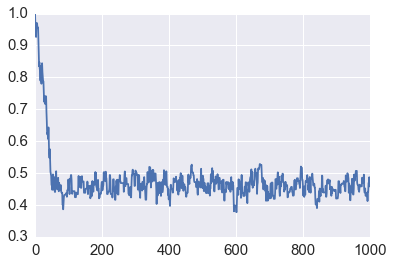

In [22]:
#Plot sigma_A
plt.plot(np.arange(1000), np.squeeze(chain_sigma_A, axis=(1,)))
plt.show()

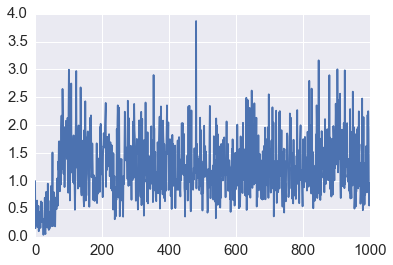

In [23]:
#Plot alpha
plt.plot(np.arange(1000), np.squeeze(chain_alpha, axis=(1,)))
plt.show()

In [24]:
K_post_choice = 5
final_Z = chain_Z[999,:,0:K_post_choice]
post_sigma_X_mean = np.mean(np.squeeze(chain_sigma_X, axis=(1,))[50:])
post_sigma_A_mean = np.mean(np.squeeze(chain_sigma_A, axis=(1,))[50:])
M_fin = np.linalg.inv(np.dot(final_Z.T, final_Z) + (post_sigma_X_mean**2/post_sigma_A_mean**2) * np.eye(K_post_choice))
post_exp_A  = np.dot(M_fin, np.dot(final_Z.T, data))

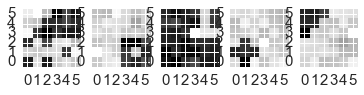

In [25]:
##Latent Features
fig = plt.figure()
a=fig.add_subplot(1,5,1)
plt.imshow(post_exp_A[0,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,2)
plt.imshow(post_exp_A[1,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,3)
plt.imshow(post_exp_A[2,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,4)
plt.imshow(post_exp_A[3,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')
a=fig.add_subplot(1,5,5)
plt.imshow(post_exp_A[4,:].reshape(6,6),cmap=plt.get_cmap('gray'),  interpolation='nearest',origin='lower')

Profiling
====

In [33]:
def profiler(n):

    data = image_data

    #Set number of iterations
    E = 1000

    #Set truncation limit for max number of sampled latent features
    K_inf = 20

    #Set storage arrays for sampled parameters
    chain_Z = np.zeros([E, num_objects, K_inf])
    chain_K = np.zeros([E, 1])
    chain_sigma_X = np.zeros([E, 1])
    chain_sigma_A = np.zeros([E, 1])
    chain_alpha = np.zeros([E, 1])

    #Initialize parameter values
    sigma_X = 1
    sigma_A = 1
    alpha = 1
    num_object= np.shape(data)[0]
    object_dim = np.shape(data)[1]
    [Z, K_plus] = sampleIBP(alpha, num_objects)

    #Compute Harmonic Number
    HN = 0
    for i in range(0, num_objects):
        HN = HN + 1/(i+1)

    for e in range(0, E):

        #Store sampled values
        chain_Z[e, :, 0:K_plus] = Z[:, 0:K_plus]
        chain_K[e] = K_plus
        chain_sigma_X[e] = sigma_X
        chain_sigma_A[e] = sigma_A
        chain_alpha[e] = alpha
    
        if (e%100==0):
            print(e)
    
        print("At iteration", e, ": K_plus is", K_plus, ", alpha is", alpha) 

        #Generate a new value for Z[i,k] and accept by Metropolis
        for i in range(0, num_objects):
            #First we remove singular features if any
            for k in range(0, K_plus):
                if (k>=K_plus):
                    break
                if(Z[i, k] > 0):
                    if (np.sum(Z[:, k]) - Z[i, k]) <= 0: 
                        Z[i, k] = 0
                        Z[:, k:(K_plus - 1)] = Z[:, (k+1):K_plus]
                        K_plus = K_plus - 1
                        Z = Z[:, 0:K_plus]
                        continue
                #Compute conditional distribution for current cell
                P=np.zeros(2)

                Z[i,k]=1
                P[0] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(np.sum(Z[:, k]) - Z[i,k]) - np.log(num_objects)

                Z[i,k]=0
                P[1] = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim) + np.log(num_objects - np.sum(Z[:,k])) - np.log(num_objects)

                P = np.exp(P - np.max(P))

                #Sample from conditional(sampling previously sampled dishes)
                if np.random.uniform(0,1) < (P[0]/(np.sum(P))):
                    Z[i, k] = 1
                else:
                    Z[i, k] = 0
                
            #Sample new dishes by Metropolis
            trunc = np.zeros(5)
            alpha_N = alpha/num_objects

            for k_i in range(0,5):
                Z_temp = Z
                if k_i>0:
                    newcol = np.zeros((num_objects, k_i))
                    newcol[i,:] = 1 
                    Z_temp = np.column_stack((Z_temp, newcol))
                trunc[k_i] = k_i * np.log(alpha_N) - alpha_N - np.log(np.math.factorial(k_i)) + likelihood_opt(data, Z_temp,sigma_A, sigma_X, K_plus+k_i, num_objects, object_dim)

            trunc = np.exp(trunc - np.max(trunc))
            trunc = trunc/np.sum(trunc)

            p = np.random.uniform(0,1)
            t = 0
            new_dishes = 0

            for k_i in range(0,5):
                t = t + trunc[k_i]
                if p < t:
                    new_dishes = k_i
                    break

            if(new_dishes > 0):
                newcol = np.zeros((num_objects, new_dishes))
                newcol[i,:] = 1
                Z = np.column_stack((Z, newcol))
            K_plus = K_plus + new_dishes

        #Sample sigma_X and sigma_A through Metropolis
        lik_curr = likelihood_opt(data, Z, sigma_A, sigma_X, K_plus, num_objects, object_dim)

        if np.random.uniform(0,1) < 0.5:
            sigma_X_new = sigma_X - np.random.uniform(0,1)/20
        else:
            sigma_X_new = sigma_X + np.random.uniform(0,1)/20

        lik_new_X = likelihood_opt(data, Z, sigma_A, sigma_X_new, K_plus, num_objects, object_dim)

        acc_X = np.exp(min(0, lik_new_X - lik_curr))

        if np.random.uniform(0,1) < 0.5:
            sigma_A_new = sigma_A - np.random.uniform(0,1)/20
        else:
            sigma_A_new = sigma_A + np.random.uniform(0,1)/20

        lik_new_A = likelihood_opt(data, Z, sigma_A_new, sigma_X, K_plus, num_objects, object_dim)

        acc_A = np.exp(min(0, lik_new_A - lik_curr))

        if np.random.uniform(0,1) < acc_X:
            sigma_X = sigma_X_new
        if np.random.uniform(0,1) < acc_A:
            sigma_A = sigma_A_new

        #Sample alpha via Gibbs
        alpha = np.random.gamma(1 + K_plus, 1/(1+HN))

    print("Complete")

In [34]:
%prun -q -D profiler.prof profiler(int(1000))

0
At iteration 0 : K_plus is 7 , alpha is 1
At iteration 1 : K_plus is 4 , alpha is 0.39347561702104566
At iteration 2 : K_plus is 4 , alpha is 1.0677597293276997
At iteration 3 : K_plus is 4 , alpha is 0.777163121364264
At iteration 4 : K_plus is 4 , alpha is 0.6736975116981749
At iteration 5 : K_plus is 4 , alpha is 0.8853346968560252
At iteration 6 : K_plus is 3 , alpha is 1.0824992142020269
At iteration 7 : K_plus is 3 , alpha is 0.4545776622746425
At iteration 8 : K_plus is 3 , alpha is 0.6976644325346196
At iteration 9 : K_plus is 3 , alpha is 0.3843703506992804
At iteration 10 : K_plus is 3 , alpha is 0.5549007978566551
At iteration 11 : K_plus is 3 , alpha is 0.38621774933062425
At iteration 12 : K_plus is 3 , alpha is 0.3834347800604111
At iteration 13 : K_plus is 3 , alpha is 0.41005523842985664
At iteration 14 : K_plus is 3 , alpha is 0.2220100545998562
At iteration 15 : K_plus is 3 , alpha is 0.6403744121669424
At iteration 16 : K_plus is 3 , alpha is 0.3881994903928051
At 

In [35]:
import pstats
p = pstats.Stats('profiler.prof')
p.print_stats()
pass

Tue Apr 26 17:04:49 2016    profiler.prof

         131508227 function calls in 1093.118 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.019    0.000    0.712    0.001 C:\Users\Drew\Anaconda3\lib\site-packages\ipykernel\iostream.py:151(flush)
     1000    0.024    0.000    0.161    0.000 C:\Users\Drew\Anaconda3\lib\site-packages\zmq\sugar\socket.py:289(send_multipart)
  3805516    9.939    0.000   15.732    0.000 C:\Users\Drew\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:209(_assertNdSquareness)
  3805516   36.575    0.000   65.823    0.000 C:\Users\Drew\Anaconda3\lib\site-packages\numpy\lib\twodim_base.py:192(eye)
     1000    0.016    0.000    0.251    0.000 C:\Users\Drew\Anaconda3\lib\site-packages\jupyter_client\session.py:541(serialize)
  3807045    4.041    0.000    4.041    0.000 {built-in method builtins.max}
     1000    0.013    0.000    0.013    0.000 C:\Users\Drew\Anaconda3\lib\uuid.py:2